# Import and function definition

## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files

In [2]:
# If you want to save plot in latex format
!pip install tikzplotlib
import tikzplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 54 kB 2.1 MB/s 


## Function for simulation V1 (OLD)

In [3]:
def simulation_V1(N, t_generation, rate, tot_time_simulation = 100000):
  """
  Function 
  """

  scale = 1 / rate

  # Variable to save packet related data
  queue = []
  waiting_time = []
  time_in_queue_per_packet = [] # Save the aoi during the simulation
  final_aoi = [] # Save the final aoi for a packet

  # Simulation step (equals to the interval needed to generate a new packet)
  simulation_step = t_generation / N

  actual_time = 0

  while(tot_time_simulation > actual_time):
    # Reduce the time of the first user in the queue (if there are user)
    if(len(queue) > 0): waiting_time[0] -= simulation_step

    # Iterate through the packet in the queue to evaluate how time they spent in the queue
    idx_to_remove = []
    for i in range(len(queue)):
      if(waiting_time[i] > 0): # If the waiting time is bigger than 0 they have to wait. So I add the simulation step
        time_in_queue_per_packet[i] += simulation_step
      else: # If the waiting time is equal or less than 0 it means that the packet was processed
        # Calculate the difference between the time step and the actual non positive waiting time
        # (This is needed due the fact that the simulation is discrete with a predefined step)
        time_adjustement = waiting_time[i] + simulation_step

        # Calculate the final amount of time spent in the system
        time_in_queue_per_packet[i] += time_adjustement

        # Save the final AoI for the current packet
        final_aoi.append(time_in_queue_per_packet[i])

        # Add the index to the list of element to remove
        # This is needed in case the waiting time of the next element is less or equal than the time_adjustment. 
        # In this case in the time of a single generation cycle more than 1 packet is processed 
        idx_to_remove.append(i)

        # Correct the waiting time for the next packet in the queue (if there are packet in the queue)
        if(len(queue) < i + 1): waiting_time[i + 1] -= time_adjustement

    # Remove all packet processed in this iteration
    for idx in sorted(idx_to_remove, reverse=True):
        del queue[idx]
        del time_in_queue_per_packet[idx]
        del waiting_time[idx]

    # Generate new packet
    queue.append(1)
    waiting_time.append(np.random.exponential(scale = scale))
    time_in_queue_per_packet.append(0)

    actual_time += simulation_step

  return np.mean(final_aoi)

## Function for simulation V2

### Preprocess

In [4]:
def preprocess_deterministic(N, tot_time_simulation, generation_time):
  if(generation_time <= 0): raise Exception("generation_time must be positive (N.b. generation_time is the time between the generation of 2 subsequent update)")
  
  # Finale variable to return that contain the list of waiting time and the relative label for each time
  arrival_time_list = []
  arrival_time_label = []

  t = 0
  label = 0

  while(True):
    arrival_time_list.append(t)
    arrival_time_label.append(label)

    t += generation_time
    label += 1

    if(t > tot_time_simulation * 1.1): break
    if(label >= N): label = 0

  return np.asarray(arrival_time_list), np.asarray(arrival_time_label)


def preprocess_exp(N, tot_time_simulation, **kwargs):
  # Variable declaration

  # Finale variable to return that contain the list of waiting time and the relative label for each time
  arrival_time_list = np.zeros(0)
  arrival_time_label = np.zeros(0)

  # Vector that contain the label for new generated waiting time vector
  tmp_label = np.asarray([int(i) for i in range(N)])

  # Last N waiting time generated (1 for each sensor/node/etc)
  last_waiting_time = np.zeros(N)

  # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
  
  # Check input data
  # if(type_generation != 0 and type_generation != 1):
  #   exception_string = "Wrong type_generation. The possible values are 0 (DETERMINISTIC), 1 (EXPONENTIAL)"
  #   raise Exception(exception_string)

  if("scale" not in kwargs): raise Exception("For EXPONENTIAL time generation you must pass the scale parameter")

  # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
  # Waiting time creation

  # Random generation process
  while(True):
    # Generate waiting time according to distribution
    tmp_waiting_time = np.random.exponential(scale = kwargs['scale'], size = N)

    # Shift new waiting time according to the previous generated waiting time for each node
    tmp_waiting_time += last_waiting_time

    # Concatenate waiting time and label
    arrival_time_list = np.concatenate((arrival_time_list, tmp_waiting_time))
    arrival_time_label = np.concatenate((arrival_time_label, tmp_label))

    # Save the last generated (and shifted) waiting time to use them in the new cycle
    last_waiting_time = tmp_waiting_time

    # Check if I have generated enough waiting time
    if(np.max(last_waiting_time) >= tot_time_simulation): break

    # print(np.max(last_waiting_time))

  # Sort indices based on waiting time
  sorted_idx = np.argsort(arrival_time_list)

  # Sort waiting time and labels
  arrival_time_list = arrival_time_list[sorted_idx]
  arrival_time_label = arrival_time_label[sorted_idx]

  return arrival_time_list, arrival_time_label.astype(int)


### Simulation

In [5]:
def simulation_V2(N, tot_time_simulation, service_rate, arrival_time_list, arrival_time_label, simulation_step = -1, laura_correction = False):
  """
  Function 
  """

  service_scale = 1 / service_rate

  # Variable to save packet related data
  queue = [arrival_time_label[0]] # Already insert the first element in the queue
  time_in_queue = [0]
  process_time = [np.random.exponential(scale = service_scale)]
  aoi_list_per_sensor = [[] for i in range(N)]
  current_aoi_per_sensor = np.zeros(N)

  # Simulation step (equals to the interval needed to generate a new packet)
  if(simulation_step <= 0): simulation_step = 0.1

  actual_time = 0

  # Index for the arrival_time_list and arrival_time_label
  idx_packet_generated = 1

  if(laura_correction): 
    laura_correction_factor_per_sensor = [[] for i in range(N)]
    laura_idx = 0

  # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
  # Simulation
  while(tot_time_simulation > actual_time):
    # Reduce the time of the first user in the queue (if there are user)
    if(len(queue) > 0): process_time[0] -= simulation_step

    # Iterate through the packet in the queue to evaluate how time they spent in the queue
    idx_to_remove = []
    for i in range(len(queue)):
      if(process_time[i] > 0): # If the waiting time is bigger than 0 they have to wait.
        time_in_queue[i] += simulation_step
        pass
      else: # If the waiting time is equal or less than 0 it means that the packet was processed
        # Calculate the difference between the time step and the actual non positive waiting time
        # (This is needed due the fact that the simulation is discrete with a predefined step)
        time_adjustement = process_time[i] + simulation_step

        # Calculate the final amount of time spent in the system
        current_aoi_per_sensor[queue[i]] += time_adjustement
        # N.b. In the queue I save the label of the current packet

        # Save the final AoI for the current packet
        aoi_list_per_sensor[queue[i]].append(current_aoi_per_sensor[queue[i]])

        # Correct time passed in the queue
        time_in_queue[i] -= time_adjustement

        # Reset AoI for the current sensor
        # current_aoi_per_sensor[queue[i]] = abs(process_time[i])
        current_aoi_per_sensor[queue[i]] = time_in_queue[i]

        # Add the index to the list of element to remove
        # This is needed in case the waiting time of the next element is less or equal than the time_adjustment. 
        # In this case in the time of a single generation cycle more than 1 packet is processed 
        idx_to_remove.append(i)

        # Correct the waiting time for the next packet in the queue (if there are packet in the queue)
        if(len(queue) < i + 1): process_time[i + 1] -= time_adjustement

        if(laura_correction): laura_correction_factor_per_sensor[queue[i]].append(time_in_queue[i])

    # Remove all packet processed in this iteration
    for idx in sorted(idx_to_remove, reverse = True):
        del queue[idx]
        del process_time[idx]

    actual_time += simulation_step

    current_aoi_per_sensor += simulation_step

    # Generate new packet(s)
    if(idx_packet_generated < len(arrival_time_label)):
      while(actual_time >= arrival_time_list[idx_packet_generated]):
        queue.append(arrival_time_label[idx_packet_generated].astype(int))
        time_in_queue.append(0)
        process_time.append(np.random.exponential(scale = service_scale))

        # If the queue is of length 1 it means that before this packet was empty
        # So I have to adjust the time that remain to spent in the queue
        if(len(queue) == 1):
          time_adjustement = actual_time - arrival_time_list[idx_packet_generated]
          process_time[0] -= time_adjustement

        idx_packet_generated += 1

      # print(actual_time, len(queue))
  # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

  if(laura_correction): 
    return aoi_list_per_sensor, laura_correction_factor_per_sensor
  else:
    return aoi_list_per_sensor

### Compute AoI functions

In [6]:
def compute_final_aoi_per_sensor(aoi_list_per_sensor, correction_list_per_sensor = []):
  final_aoi_per_sensor = []

  for i in range(len(aoi_list_per_sensor)): 
    aoi_list = aoi_list_per_sensor[i]

    if(len(correction_list_per_sensor) != 0): correction_list = correction_list_per_sensor[i]
    else: correction_list = []

    final_aoi_per_sensor.append(compute_aoi_given_delta(aoi_list, correction_list))

  return final_aoi_per_sensor

def compute_aoi_given_delta(delta_list, correction_list = []):
    if(len(correction_list) > 0):
      numerator = 0
      for i in range(len(delta_list)): numerator += ((delta_list[i] ** 2) / 2) + correction_list[i] * delta_list[i]
    else:
      numerator = np.sum(np.power(delta_list, 2)) / 2
    
    denominator = np.mean(delta_list) * len(delta_list)
    
    aoi = numerator/denominator

    return aoi

# SIMULATION V1

## For specific settings


In [ ]:
# Number of sensors
N = 15

# Second to generate a packet
t_generation = 0.06

# Average rate of service for the server in second
rate = N + 2
scale = 1 / rate

# Total seconds to simulate
tot_time_simulation = 100000

average_aoi = simulation_V1(N, t_generation, rate, tot_time_simulation)
print("Average AoI = ", average_aoi)

Average AoI =  176.8616159220195


## For multiple rate setting

Given fixed N and t_generation try the simulation for multiple rate


In [ ]:
# Number of sensors
N = 15

# Second to generate a packet
t_generation = 5

# Total seconds to simulate
tot_time_simulation = 30000

rate_array = np.linspace(N, 2*N, 50)

average_aoi_list = []

print_var = False

for i in range(len(rate_array)):
  rate = rate_array[i]

  average_aoi = simulation_V1(N, t_generation, rate, tot_time_simulation)
  average_aoi_list.append(average_aoi)

  if(print_var): print("Percentage complete:\t {}%".format(round(i/len(rate_array) * 100, 2)))

## Plot for simulation with multiple rate

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

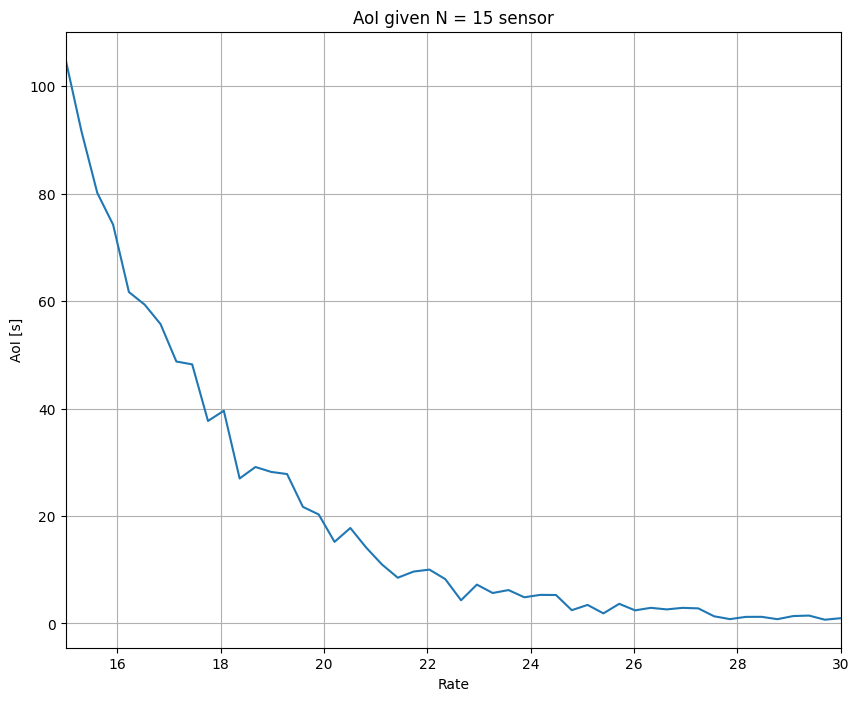

In [ ]:
plt.figure(figsize = (10, 8))
plt.plot(rate_array, average_aoi_list)

plt.xlabel("Rate")
plt.ylabel("AoI [s]")
plt.title("AoI given N = {} sensor".format(N))

plt.xlim([rate_array[0], rate_array[-1]])
plt.grid(True)

tikzplotlib.save("test.tex")
files.download("test.tex")

# SIMULATION (V2)

singola

Average AoI =  10.203061443261726 (No correction)
Average AoI =  1505.7142914534102 (Correction)


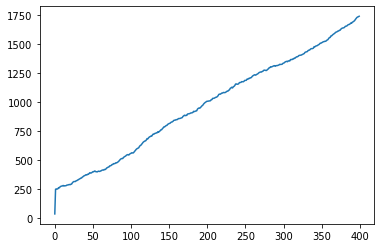

In [21]:
# Number of sensors
N = 15

# Average rate of service for the server in second
generation_rate = 1/0.06

# Average rate of service for the server in second
service_rate = 1

# Total seconds to simulate
tot_time_simulation = 100000

laura_correction = True

# arrival_time_list, arrival_time_label = preprocess_exp(N, tot_time_simulation, scale = 1 /generation_rate)
arrival_time_list, arrival_time_label = preprocess_deterministic(N, tot_time_simulation, generation_rate)

aoi_list_per_sensor, laura_correction_factor_per_sensor = simulation_V2(N, tot_time_simulation, service_rate, arrival_time_list, arrival_time_label, simulation_step = 1/service_rate, laura_correction = laura_correction)
print("Average AoI = ", np.mean(compute_final_aoi_per_sensor(aoi_list_per_sensor)), "(No correction)")
print("Average AoI = ", np.mean(compute_final_aoi_per_sensor(aoi_list_per_sensor, laura_correction_factor_per_sensor)), "(Correction)")

plt.plot(aoi_list_per_sensor[2])

multipli service rate

In [ ]:
# Number of sensors
N = 15

# Average rate of service for the server in second
generation_rate = N - 2

# Total seconds to simulate
tot_time_simulation = 3500

rate_array = np.linspace(5, 70, 80)

# average_aoi_list = []
# average_aoi_with_correction_list = []

print_var = False
laura_correction = True

# arrival_time_list, arrival_time_label = preprocess_exp(N, tot_time_simulation, scale = 1 /generation_rate)
arrival_time_list, arrival_time_label = preprocess_deterministic(N, tot_time_simulation, generation_rate)

repetition = 12
final_aoi_matrix = np.zeros((repetition, len(rate_array)))
final_aoi_matrix_with_correction = np.zeros((repetition, len(rate_array)))

for rep in range(repetition):
  for i in range(len(rate_array)):
    service_rate = rate_array[i]

    aoi_list_per_sensor, laura_correction_factor_per_sensor = simulation_V2(N, tot_time_simulation, service_rate, arrival_time_list, arrival_time_label, simulation_step = 1/service_rate, laura_correction = laura_correction)
    # average_aoi_list.append(np.mean(compute_final_aoi_per_sensor(aoi_list_per_sensor)))
    # average_aoi_with_correction_list.append(np.mean(compute_final_aoi_per_sensor(aoi_list_per_sensor, laura_correction_factor_per_sensor)))

    if(print_var): print("Percentage complete:\t {}%".format(round(i/len(rate_array) * 100, 2)))

    final_aoi_matrix[rep, i] = np.mean(compute_final_aoi_per_sensor(aoi_list_per_sensor))
    final_aoi_matrix_with_correction[rep, i] = np.mean(compute_final_aoi_per_sensor(aoi_list_per_sensor, laura_correction_factor_per_sensor))

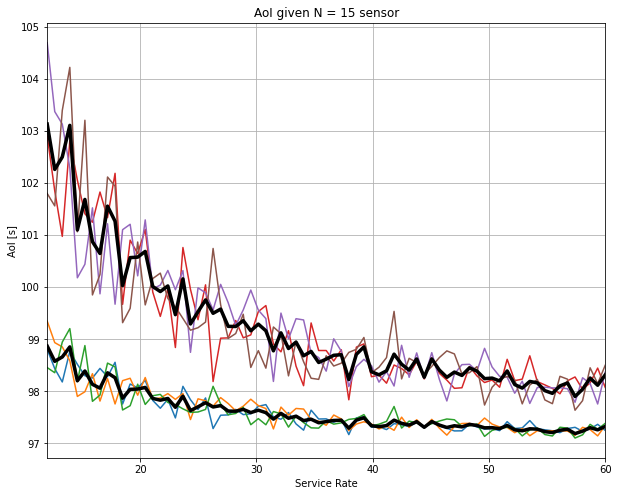

In [ ]:
save_tikz = False

plt.figure(figsize = (10, 8))
# plt.plot(rate_array, average_aoi_list)
# plt.plot(rate_array, average_aoi_with_correction_list)

for i in range(repetition): plt.plot(rate_array, final_aoi_matrix[i])
for i in range(repetition): plt.plot(rate_array, final_aoi_matrix_with_correction[i])

plt.plot(rate_array, np.mean(final_aoi_matrix, 0), color = 'black', linewidth = 3.5)
plt.plot(rate_array, np.mean(final_aoi_matrix_with_correction, 0), color = 'black', linewidth = 3.5)

plt.xlabel("Service Rate")
plt.ylabel("AoI [s]")
plt.title("AoI given N = {} sensor".format(N))
# plt.legend(["AoI (NO Correction)", "AoI (WITH Correction)"])

plt.xlim([rate_array[0], rate_array[-1]])
plt.grid(True)

if(save_tikz):
  tikzplotlib.save("test.tex")
  files.download("test.tex")

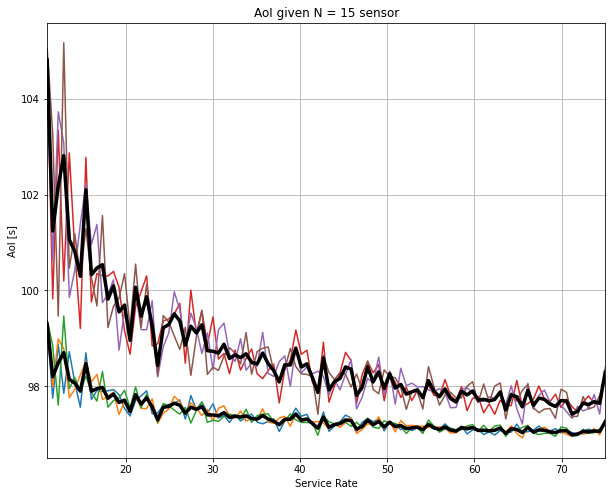

In [ ]:
plt.figure(figsize = (10, 8))
# plt.plot(rate_array, average_aoi_list)
# plt.plot(rate_array, average_aoi_with_correction_list)

for i in range(repetition): plt.plot(rate_array, final_aoi_matrix[i])
for i in range(repetition): plt.plot(rate_array, final_aoi_matrix_with_correction[i])

plt.plot(rate_array, np.mean(final_aoi_matrix, 0), color = 'black', linewidth = 3.5)
plt.plot(rate_array, np.mean(final_aoi_matrix_with_correction, 0), color = 'black', linewidth = 3.5)

plt.xlabel("Service Rate")
plt.ylabel("AoI [s]")
plt.title("AoI given N = {} sensor".format(N))
# plt.legend(["AoI (NO Correction)", "AoI (WITH Correction)"])

plt.xlim([rate_array[0], rate_array[-1]])
plt.grid(True)

if(save_tikz):
  tikzplotlib.save("test.tex")
  files.download("test.tex")

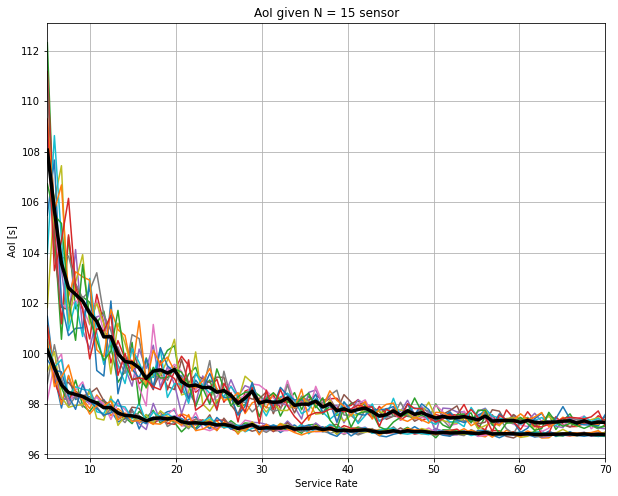

In [ ]:
plt.figure(figsize = (10, 8))
# plt.plot(rate_array, average_aoi_list)
# plt.plot(rate_array, average_aoi_with_correction_list)

for i in range(repetition): plt.plot(rate_array, final_aoi_matrix[i])
for i in range(repetition): plt.plot(rate_array, final_aoi_matrix_with_correction[i])

plt.plot(rate_array, np.mean(final_aoi_matrix, 0), color = 'black', linewidth = 3.5)
plt.plot(rate_array, np.mean(final_aoi_matrix_with_correction, 0), color = 'black', linewidth = 3.5)

plt.xlabel("Service Rate")
plt.ylabel("AoI [s]")
plt.title("AoI given N = {} sensor".format(N))
# plt.legend(["AoI (NO Correction)", "AoI (WITH Correction)"])

plt.xlim([rate_array[0], rate_array[-1]])
plt.grid(True)

if(save_tikz):
  tikzplotlib.save("test.tex")
  files.download("test.tex")